In [4]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

In [3]:
datam = pd.read_excel('database_bencana_mentah_update.xlsx')

In [85]:
datam = datam.drop_duplicates()

In [86]:
datam['banjir'].value_counts()

1    13580
0     2197
Name: banjir, dtype: int64

In [122]:
datam.to_excel('database_bencana_mentah_update.xlsx', index=False)

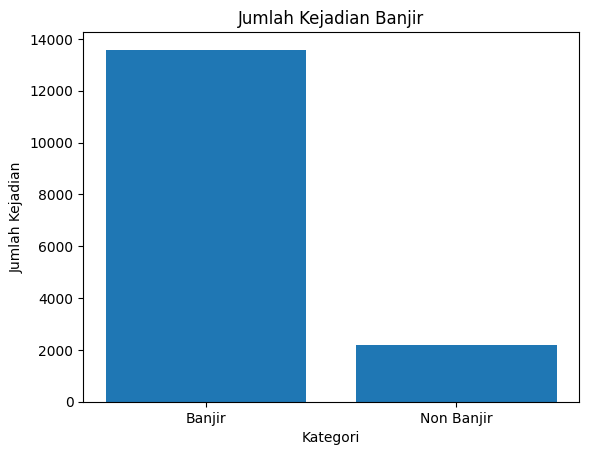

In [88]:
import matplotlib.pyplot as plt

# Memisahkan datam berdasarkan nilai variabel 'banjir'
banjir_datam = datam[datam['banjir'] == 1]
non_banjir_datam = datam[datam['banjir'] == 0]

# Menghitung jumlah kejadian banjir dan non banjir
banjir_count = banjir_datam.shape[0]
non_banjir_count = non_banjir_datam.shape[0]

# Membuat grafik batang
labels = ['Banjir', 'Non Banjir']
values = [banjir_count, non_banjir_count]

plt.bar(labels, values)
plt.xlabel('Kategori')
plt.ylabel('Jumlah Kejadian')
plt.title('Jumlah Kejadian Banjir')
plt.show()


In [29]:
# Memisahkan fitur dan label
X = data.drop('banjir', axis=1)
y = data['banjir']

# Membuat objek RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Melakukan undersampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Menggabungkan kembali fitur dan label yang telah diundersample
undersampled_data = pd.concat([X_resampled, y_resampled], axis=1)

In [30]:
undersampled_data['banjir'].value_counts()

0    2197
1    2197
Name: banjir, dtype: int64

In [ ]:
undersampled_data

In [33]:
undersampled_data.to_excel('data_bencana_resample_mentah_baru.xlsx', index=False)

In [5]:
data = pd.read_excel("data_bencana_resample_mentah_baru.xlsx")

In [46]:
data = undersampled_data

In [7]:
datam.columns

Index(['latitude', 'longitude', 'Meninggal', 'Hilang', 'Terluka', 'Menderita',
       'Mengungsi', 'Rumah', 'Fas_Pendidikan', 'Fas_Kesehatan',
       'Fas_Peribadatan', 'Fas_Umum', 'Perkantoran', 'Jembatan', 'Pabrik',
       'Pertokoan', 'tanggal', 'hari', 'bulan', 'tahun', 'hari_dalam_pekan',
       'pekan_ke', 'banjir', 'provinsi', 'kabupaten'],
      dtype='object')

In [6]:
data.columns

Index(['latitude', 'longitude', 'Meninggal', 'Hilang', 'Terluka', 'Menderita',
       'Mengungsi', 'Rumah', 'Fas_Pendidikan', 'Fas_Kesehatan',
       'Fas_Peribadatan', 'Fas_Umum', 'Perkantoran', 'Jembatan', 'Pabrik',
       'Pertokoan', 'tanggal', 'hari', 'bulan', 'tahun', 'hari_dalam_pekan',
       'pekan_ke', 'provinsi', 'kabupaten', 'banjir'],
      dtype='object')

In [58]:
import datetime
import numpy as np
import pandas as pd
import requests
import json

RESOLUTIONS = ["hourly", "daily", "monthly", "climatology"]
COMMUNITIES = ["RE", "SB", "AG"]

def point(
    *, coordinates, parameters, start, end, resolution="daily", community="RE",
):
    # Validate and parse the coordinates
    if pd.api.types.is_list_like(coordinates):
        if len(coordinates) != 2:
            raise ValueError("Coordinate list should have 2 values")
        latitude, longitude = coordinates
    if isinstance(coordinates, dict):
        if "lat" not in coordinates:
            raise ValueError("Coordinates does not contain a 'lat' key")
        if "lon" not in coordinates.index:
            raise ValueError("Coordinates does not contain a 'lon' key")
        latitude = coordinates["lat"]
        longitude = coordinates["lon"]
    if isinstance(coordinates, pd.core.series.Series):
        if "lat" not in coordinates.index:
            raise ValueError("Coordinates does not have 'lat' in index")
        if "lat" not in coordinates.index:
            raise ValueError("Coordinates does not have 'lat' in index")
        latitude = coordinates["lat"]
        longitude = coordinates["lon"]
    if not isinstance(latitude, int) and not isinstance(latitude, float):
        raise TypeError("Latitude should be an integer or float")
    if not isinstance(longitude, int) and not isinstance(longitude, float):
        raise TypeError("Longitude should be an integer or float")
    if not isinstance(latitude, (int, float, str, np.number)):
        raise TypeError("Latitude should be a number")
    if not isinstance(longitude, (int, float, str, np.number)):
        raise TypeError("Longitude should be a number")
    if latitude < -90 or latitude > 90:
        raise ValueError("Latitude should be between -90 and 90")
    if longitude < 0 or longitude > 360:
        raise ValueError("Longitude should be between 0 and 360")

    # Validate the community
    if community not in COMMUNITIES:
        raise ValueError(f"Community should be one of {COMMUNITIES}")

    # Validate the parameters
    if not isinstance(parameters, list):
        raise TypeError("Parameters should be a list")

    # Validate the resolution
    if resolution not in RESOLUTIONS:
        raise TypeError(f"Resolution should be one of {RESOLUTIONS}")

    # Validate the start and end date
    if resolution in ["hourly", "daily"]:
        if not isinstance(start, (datetime.datetime, datetime.date)):
            raise TypeError("Start should be a datetime or date")
        if not isinstance(end, (datetime.datetime, datetime.date)):
            raise TypeError("End should be a datetime or date")
        if start < datetime.date(1982, 1, 1) or start > datetime.date.today():
            raise ValueError("Start should be between 1982 and today")
        if end < datetime.date(1982, 1, 1) or end > datetime.date.today():
            raise ValueError("End should be between 1982 and today")
        if start > end:
            raise ValueError("Start must be before end")
    else:
        if not isinstance(start, int):
            raise TypeError("Start should be an integer")
        if not isinstance(start, int):
            raise TypeError("End should be an integer")
        if start < 1982 or start > 2020:
            raise ValueError("Start should be between 1982 and 2020")
        if end < 1982 or end > 2020:
            raise ValueError("End should be between 1982 and 2020")
        if start > end:
            raise ValueError("Start must be before end")

    # Retrieve the data
    try:
        url = f"https://power.larc.nasa.gov/api/temporal/{resolution}/point"
        params = {
            "parameters": ",".join(parameters),
            "longitude": longitude,
            "latitude": latitude,
            "start": start.strftime("%Y%m%d"),
            "end": end.strftime("%Y%m%d"),
            "community": community,
            "format": "JSON",
        }
        response = requests.get(url=url, params=params, verify=True, timeout=60)
        content = json.loads(response.content.decode("utf-8"))
    except:
        raise Exception(f"Could not fetch the data")

    # Check if there are any error messages
    if len(content.get("messages", [])) > 0:
        raise Exception(content["messages"][0])

    # Check if there are any other error messages
    details = content.get("detail", [])
    if len(details):
        raise Exception(details[0].get("msg"))

    # Transform the data into a DataFrame
    data = pd.DataFrame(content["properties"]["parameter"])
    data.index = pd.to_datetime(data.index, format="%Y%m%d")

    # Return the data
    return data

In [59]:
# Tambahkan kolom data iklim ke dalam dataframe data
data["ALLSKY_SFC_SW_DWN"] = np.nan
data["ALLSKY_SFC_LW_DWN"] = np.nan
data["CLOUD_AMT"] = np.nan
data["TS"] = np.nan
data["PRECTOTCORR"] = np.nan
data["T10M"] = np.nan
data["T10M_MAX"] = np.nan
data["T10M_MIN"] = np.nan
data["WD10M"] = np.nan
data["WS10M"] = np.nan
data["WS10M_MAX"] = np.nan
data["RH2M"] = np.nan
data["QV2M"] = np.nan
data["TQV"] = np.nan
data["PS"] = np.nan
data["GWETTOP"] = np.nan
data["PW"] = np.nan
data["ALLSKY_KT"] = np.nan

In [60]:
data.columns

Index(['latitude', 'longitude', 'Meninggal', 'Hilang', 'Terluka', 'Menderita',
       'Mengungsi', 'Rumah', 'Fas_Pendidikan', 'Fas_Kesehatan',
       'Fas_Peribadatan', 'Fas_Umum', 'Perkantoran', 'Jembatan', 'Pabrik',
       'Pertokoan', 'tanggal', 'hari', 'bulan', 'tahun', 'hari_dalam_pekan',
       'pekan_ke', 'provinsi', 'kabupaten', 'banjir', 'ALLSKY_SFC_SW_DWN',
       'ALLSKY_SFC_LW_DWN', 'CLOUD_AMT', 'TS', 'PRECTOTCORR', 'T10M',
       'T10M_MAX', 'T10M_MIN', 'WD10M', 'WS10M', 'WS10M_MAX', 'RH2M', 'QV2M',
       'TQV', 'PS', 'GWETTOP', 'PW', 'ALLSKY_KT'],
      dtype='object')

In [61]:
from tqdm import tqdm

# Iterasi melalui setiap baris data dengan indikator progres
for i in tqdm(range(len(data))):
    latitude = data.at[i, "latitude"]
    longitude = data.at[i, "longitude"]
    tanggal = data.at[i, "tanggal"]

    # Ubah tanggal menjadi objek datetime.date
    tanggal_date = datetime.date(tanggal.year, tanggal.month, tanggal.day)

    # Ambil data iklim dari fungsi point
    daily_data = point(
        coordinates=(latitude, longitude),
        parameters=["ALLSKY_SFC_SW_DWN", "ALLSKY_SFC_LW_DWN", "CLOUD_AMT", "TS",
                    "PRECTOTCORR", "T10M", "T10M_MAX", "T10M_MIN", "WD10M", "WS10M",
                    "WS10M_MAX", "RH2M", "QV2M", 'TQV', 'PS', 'GWETTOP',
                    'PW', 'ALLSKY_KT'],
        start=tanggal_date,
        end=tanggal_date,
        resolution="daily",
        community="AG",
    )

    # Masukkan data iklim ke dalam dataframe data
    data.at[i, "ALLSKY_SFC_SW_DWN"] = daily_data["ALLSKY_SFC_SW_DWN"].values[0]
    data.at[i, "ALLSKY_SFC_LW_DWN"] = daily_data["ALLSKY_SFC_LW_DWN"].values[0]
    data.at[i, "CLOUD_AMT"] = daily_data["CLOUD_AMT"].values[0]
    data.at[i, "TS"] = daily_data["TS"].values[0]
    data.at[i, "PRECTOTCORR"] = daily_data["PRECTOTCORR"].values[0]
    data.at[i, "T10M"] = daily_data["T10M"].values[0]
    data.at[i, "T10M_MAX"] = daily_data["T10M_MAX"].values[0]
    data.at[i, "T10M_MIN"] = daily_data["T10M_MIN"].values[0]
    data.at[i, "WD10M"] = daily_data["WD10M"].values[0]
    data.at[i, "WS10M"] = daily_data["WS10M"].values[0]
    data.at[i, "WS10M_MAX"] = daily_data["WS10M_MAX"].values[0]
    data.at[i, "RH2M"] = daily_data["RH2M"].values[0]
    data.at[i, "QV2M"] = daily_data["QV2M"].values[0]
    data.at[i, "TQV"] = daily_data["TQV"]
    data.at[i, "PS"] = daily_data["PS"]
    data.at[i, "GWETTOP"] = daily_data["GWETTOP"]
    data.at[i, "PW"] = daily_data["PW"]
    data.at[i, "ALLSKY_KT"] = daily_data["ALLSKY_KT"]

100%|██████████| 2573/2573 [3:47:23<00:00,  5.30s/it]  


In [62]:
data.to_excel('hasil_bencana_baru_2.xlsx',index=False)

In [63]:
data = pd.read_excel("hasil_bencana_baru_banget nih.xlsx")

In [65]:
data = data.sort_values('tanggal')

In [67]:
# Mengganti nilai -999 dengan NaN agar dapat diimputasi
data.replace(-999, np.nan, inplace=True)

# Melakukan interpolasi linear pada nilai yang hilang
data = data.interpolate(method='pad')

In [1]:
data.columns

NameError: name 'data' is not defined

In [ ]:
# Variabel yang akan dianalisis
variables = ['ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN', 'CLOUD_AMT', 'TS', 'PRECTOTCORR',
             'T10M', 'T10M_MAX', 'T10M_MIN', 'WD10M', 'WS10M', 'WS10M_MAX', 'RH2M',
             'QV2M', 'TQV', 'PS', 'GWETTOP', 'PW', 'ALLSKY_KT']

for variable in variables:
    unique_values = data[variable].unique()
    unique_values.sort()
    
    print(f"Nilai unik dan jumlahnya untuk variabel '{variable}':")
    for value in unique_values:
        count = data[data[variable] == value].shape[0]
        print(f"{value}: {count} kali")
    print()


In [2]:
data.to_excel("hasil_bencana_baru_banget nih.xlsx", index=False)

NameError: name 'data' is not defined

In [ ]:
data.columns

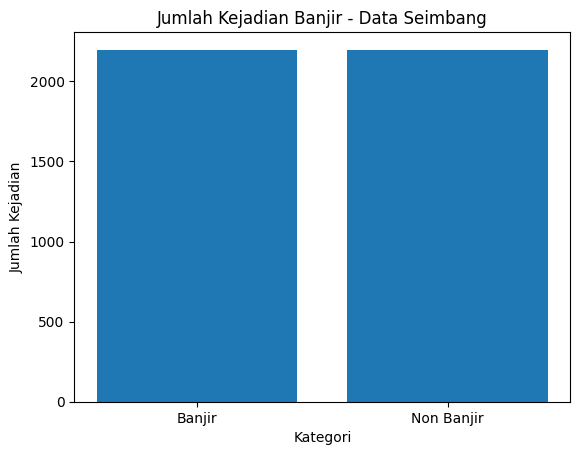

In [89]:
import matplotlib.pyplot as plt

# Memisahkan data berdasarkan nilai variabel 'banjir'
banjir_data = data[data['banjir'] == 1]
non_banjir_data = data[data['banjir'] == 0]

# Menghitung jumlah kejadian banjir dan non banjir
banjir_count = banjir_data.shape[0]
non_banjir_count = non_banjir_data.shape[0]

# Membuat grafik batang
labels = ['Banjir', 'Non Banjir']
values = [banjir_count, non_banjir_count]

plt.bar(labels, values)
plt.xlabel('Kategori')
plt.ylabel('Jumlah Kejadian')
plt.title('Jumlah Kejadian Banjir - Data Seimbang')
plt.show()


In [32]:
provinsi_counts

Jawa Tengah           2151
Jawa Timur            1675
Jawa Barat            1541
Aceh                   768
Sumatera Utara         637
Sumatera Selatan       522
Sulawesi Selatan       513
Sumatera Barat         484
Kalimantan Selatan     422
Sulawesi Tengah        386
Name: provinsi, dtype: int64

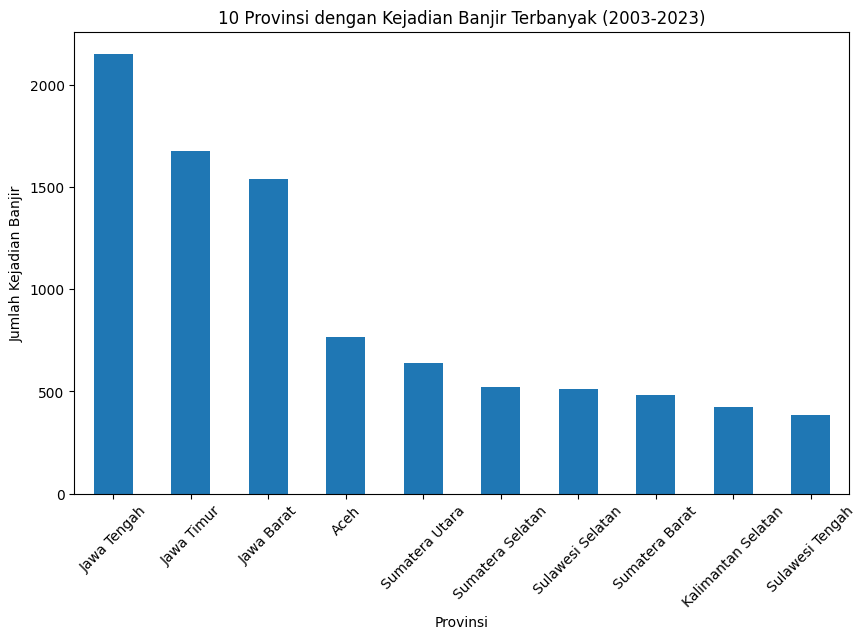

In [31]:
# Menghitung jumlah kejadian banjir per provinsi
provinsi_counts = datam[datam['banjir'] == 1]['provinsi'].value_counts().nlargest(10)

# Membuat grafik batang
plt.figure(figsize=(10, 6))
provinsi_counts.plot(kind='bar')
plt.xlabel('Provinsi')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Kejadian Banjir')
plt.title('10 Provinsi dengan Kejadian Banjir Terbanyak (2003-2023)')
plt.show()

In [33]:
kabupaten_counts

Bandung               286
Cilacap               254
Bogor                 187
Grobogan              146
Bojonegoro            144
Gresik                139
Kota Semarang         137
Pati                  132
Cirebon               125
Kota Jakarta Timur    117
Name: kabupaten, dtype: int64

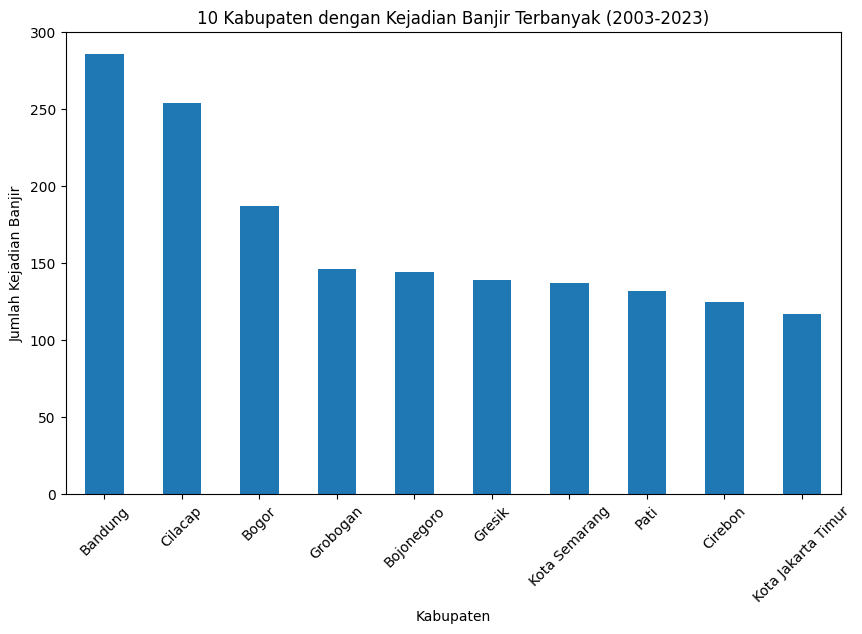

In [28]:
# Menghitung jumlah kejadian banjir per kabupaten
kabupaten_counts = datam[datam['banjir'] == 1]['kabupaten'].value_counts().nlargest(10)

# Membuat grafik batang
plt.figure(figsize=(10, 6))
kabupaten_counts.plot(kind='bar')
plt.xlabel('Kabupaten')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Kejadian Banjir')
plt.title('10 Kabupaten dengan Kejadian Banjir Terbanyak (2003-2023)')
plt.show()


In [34]:
bulan_counts

1     2293
2     2065
3     1641
4     1351
5      995
6      744
7      565
8      282
9      465
10     687
11    1037
12    1455
Name: bulan, dtype: int64

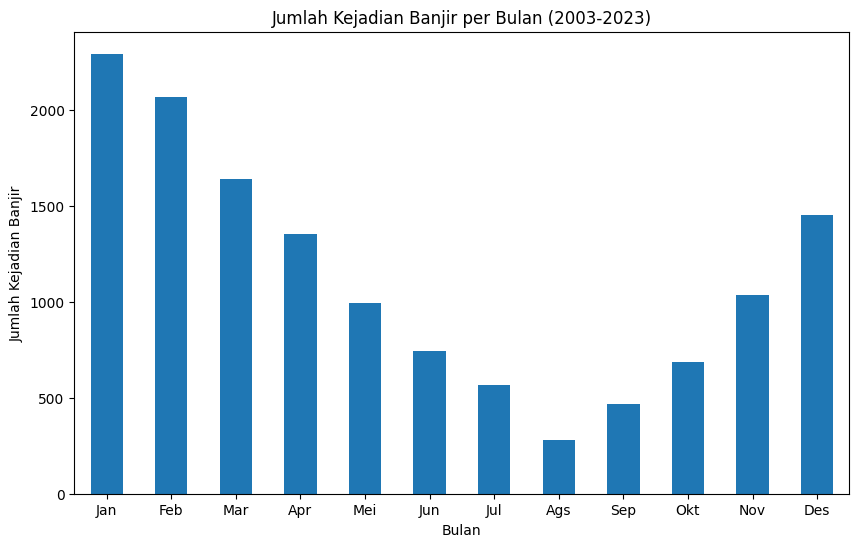

In [29]:
# Menghitung jumlah kejadian banjir per bulan
bulan_counts = datam[datam['banjir'] == 1]['bulan'].value_counts().sort_index()

# Membuat grafik batang
plt.figure(figsize=(10, 6))
bulan_counts.plot(kind='bar')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Kejadian Banjir')
plt.title('Jumlah Kejadian Banjir per Bulan (2003-2023)')

# Mengatur urutan label bulan
bulan_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'Mei', 'Jun', 'Jul', 'Ags', 'Sep', 'Okt', 'Nov', 'Des']
plt.xticks(range(len(bulan_labels)), bulan_labels)
plt.xticks(rotation=0)
plt.show()


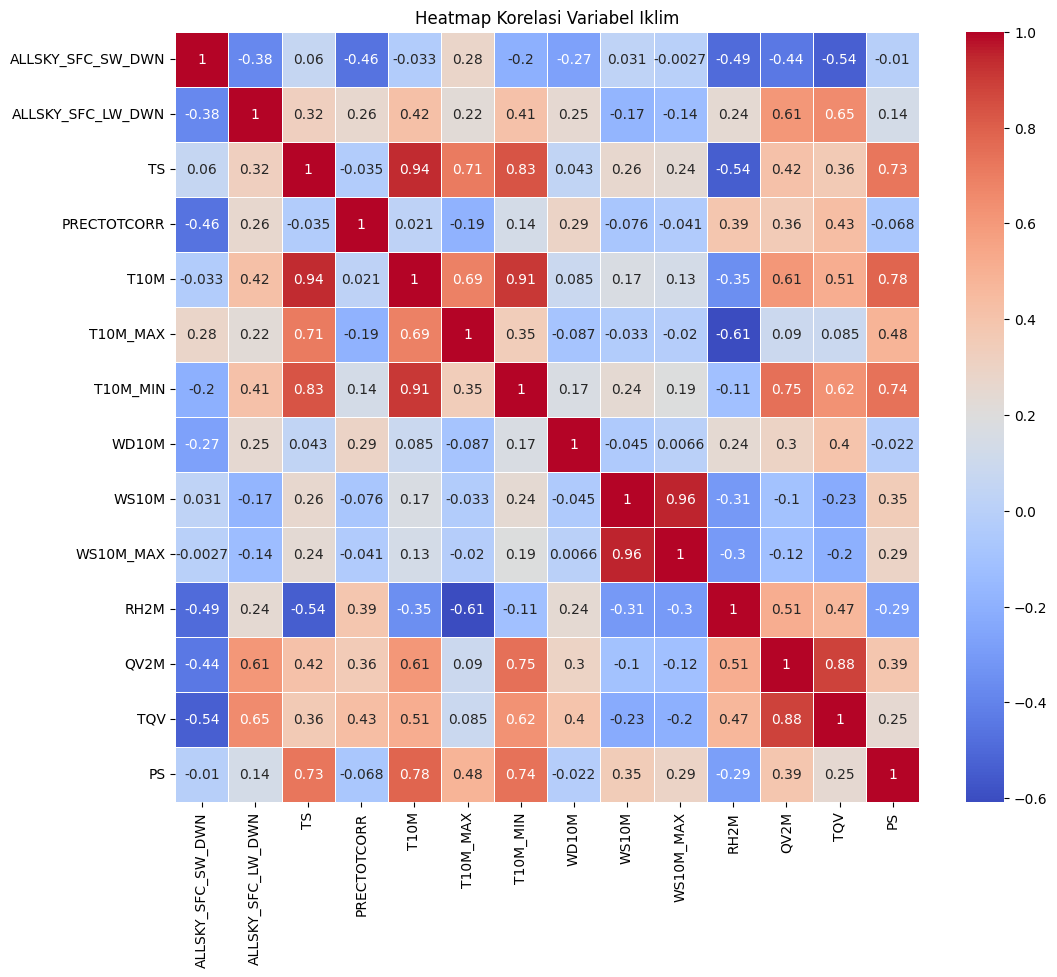

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Memilih variabel yang akan digunakan
variables = ['ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN', 'TS', 'PRECTOTCORR', 'T10M', 'T10M_MAX', 'T10M_MIN', 'WD10M', 'WS10M', 'WS10M_MAX', 'RH2M', 'QV2M', 'TQV', 'PS']

# Mengambil subset datatrain dengan variabel yang dipilih
subset_datatrain = datatrain[variables]

# Menghitung matriks korelasi
correlation_matrix = subset_datatrain.corr()

# Membuat heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Korelasi Variabel Iklim')
plt.show()

In [7]:
correlation_matrix.to_excel('heatmap.xlsx', index=True)

In [112]:
data.columns

Index(['latitude', 'longitude', 'Meninggal', 'Hilang', 'Terluka', 'Menderita',
       'Mengungsi', 'Rumah', 'Fas_Pendidikan', 'Fas_Kesehatan',
       'Fas_Peribadatan', 'Fas_Umum', 'Perkantoran', 'Jembatan', 'Pabrik',
       'Pertokoan', 'tanggal', 'hari', 'bulan', 'tahun', 'hari_dalam_pekan',
       'pekan_ke', 'provinsi', 'kabupaten', 'banjir', 'ALLSKY_SFC_SW_DWN',
       'ALLSKY_SFC_LW_DWN', 'CLOUD_AMT', 'TS', 'PRECTOTCORR', 'T10M',
       'T10M_MAX', 'T10M_MIN', 'WD10M', 'WS10M', 'WS10M_MAX', 'RH2M', 'QV2M',
       'TQV', 'PS', 'GWETTOP', 'PW', 'ALLSKY_KT'],
      dtype='object')

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Membuat peta awal dengan koordinat pusat
map = folium.Map(location=[-2.5489, 118.0149], zoom_start=4)

# Membuat cluster marker untuk titik-titik kejadian banjir
cluster_banjir = MarkerCluster(name='Banjir').add_to(map)

# Menambahkan marker untuk setiap titik kejadian banjir
for index, row in datam[datam['banjir'] == 1].iterrows():
    lat = row['latitude']
    lon = row['longitude']
    popup = f"Tanggal: {row['tanggal']}\nMeninggal: {row['Meninggal']}\nHilang: {row['Hilang']}\nTerluka: {row['Terluka']}\nMenderita: {row['Menderita']}\nMengungsi: {row['Mengungsi']}\nRumah: {row['Rumah']}\nFas_Pendidikan: {row['Fas_Pendidikan']}\nFas_Kesehatan: {row['Fas_Kesehatan']}\nFas_Peribadatan: {row['Fas_Peribadatan']}\nFas_Umum: {row['Fas_Umum']}\nPerkantoran: {row['Perkantoran']}\nJembatan: {row['Jembatan']}\nPabrik: {row['Pabrik']}\nPertokoan: {row['Pertokoan']}"
    folium.Marker(location=[lat, lon], popup=popup).add_to(cluster_banjir)

# Menambahkan kontrol layer pada peta
folium.LayerControl().add_to(map)

# Menampilkan peta
map

In [5]:
datatrain = pd.read_excel('database\data_train.xlsx')

In [14]:
datam.describe().to_excel('eda_data.xlsx')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisasi distribusi data pada kolom-kolom numerik
numeric_cols = ['Meninggal', 'Hilang', 'Terluka', 'Menderita', 'Mengungsi', 'Rumah', 'Fas_Pendidikan', 'Fas_Kesehatan',
                'Fas_Peribadatan', 'Fas_Umum', 'Perkantoran', 'Jembatan', 'Pabrik', 'Pertokoan']
for col in numeric_cols:
    sns.histplot(datam[col])
    plt.title(f'Distribusi {col}')
    plt.show()

In [ ]:
# Visualisasi jumlah kejadian banjir berdasarkan kabupaten
plt.figure(figsize=(12, 6))
sns.countplot(x='kabupaten', hue='banjir', data=datam, order=datam['kabupaten'].value_counts().index[:10])
plt.title('Jumlah Kejadian Banjir dan Kekeringan Berdasarkan Kabupaten')
plt.xticks(rotation=90)
plt.show()

In [35]:
banjir_per_tahun

2003     198
2004     299
2005     260
2006     389
2007     408
2008     458
2009     495
2010    1101
2011     578
2012     593
2013     761
2014     610
2015     531
2016     825
2017     992
2018     884
2019     815
2020    1525
2021    1156
2022     566
2023     136
Name: tahun, dtype: int64

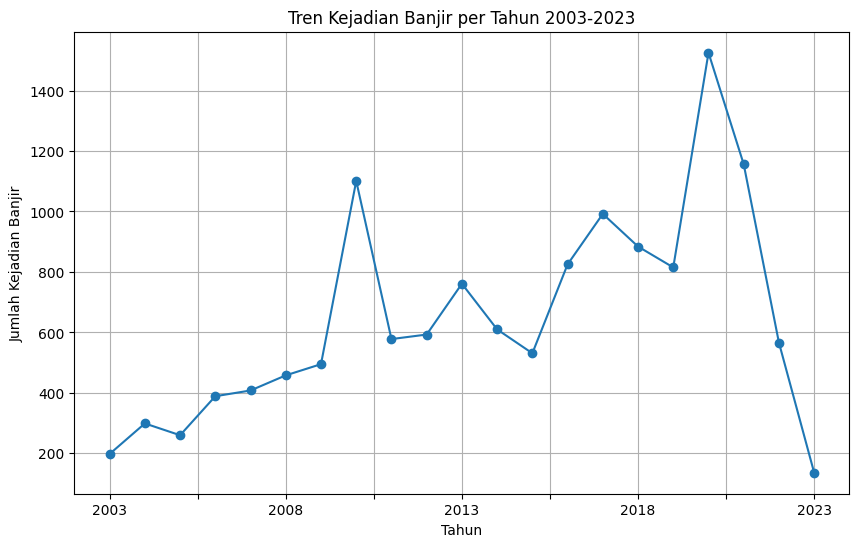

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Mengganti tipe data kolom 'tahun' menjadi string
datam['tahun'] = datam['tahun'].astype(str)

# Menghitung jumlah kejadian banjir per tahun
banjir_per_tahun = datam[datam['banjir'] == 1]['tahun'].value_counts().sort_index()

# Membuat plot tren kejadian banjir per tahun
plt.figure(figsize=(10, 6))
banjir_per_tahun.plot(marker='o')
plt.title('Tren Kejadian Banjir per Tahun 2003-2023')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Kejadian Banjir')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()